In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Read Dataset

In [3]:
import tensorflow as tf

folder_path = "/kaggle/input/teeth-set/Teeth_Dataset/Training"

dataset = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)
print(dataset.class_names)


Found 3087 files belonging to 7 classes.
['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


### Create a numpy arrays for images and labels

In [4]:
import numpy as np

X, y = [], []

for image, label in dataset:
    X.append(image)
    y.append(label)
    
X = np.concatenate(X)
y = np.concatenate(y)

### Analyze classes distribution 

In [5]:
unique, counts = np.unique(y, return_counts=True)

label_counts = dict(zip(unique, counts))

i = 0
for c in counts:
    print(f"{i} : {c}")
    i+=1
    

0 : 480
1 : 450
2 : 360
3 : 540
4 : 324
5 : 540
6 : 393


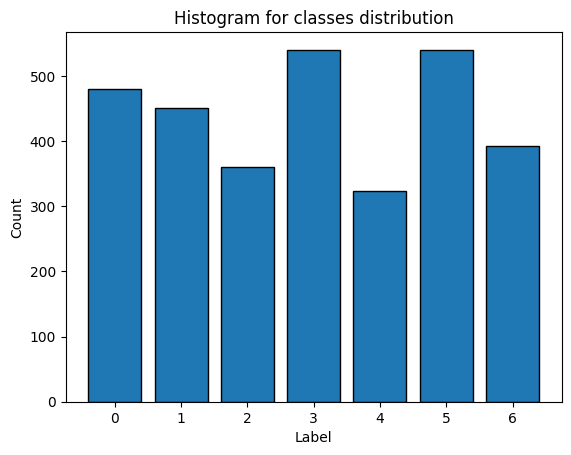

In [6]:
import matplotlib.pyplot as plt

plt.bar(unique, counts, edgecolor="black")

plt.title("Histogram for classes distribution")
plt.xlabel("Label")
plt.ylabel("Count")

plt.show()

### Create a data augmentation layer

In [7]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),         # flip left-right
    layers.RandomRotation(0.1),              # rotate ±10%
    layers.RandomZoom(0.1),                  # zoom in/out
    layers.RandomContrast(0.1),              # adjust contrast
])

### Test Augmentation by displaying images and augmentations 

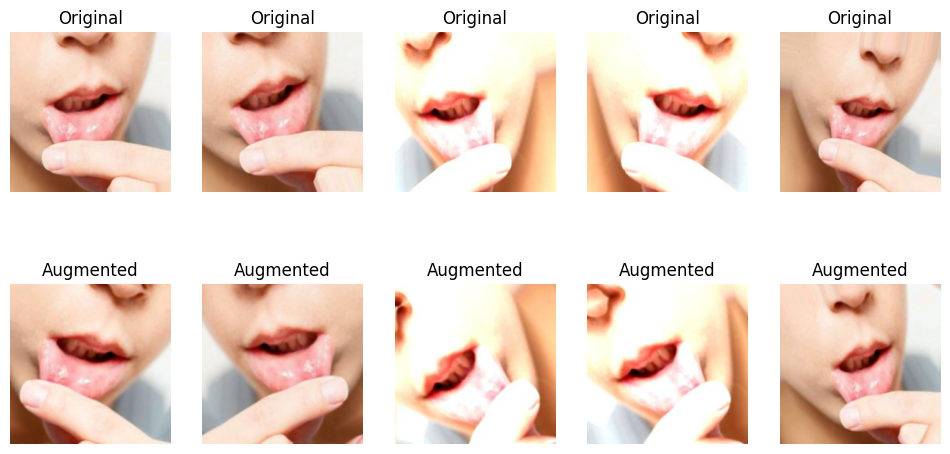

In [8]:
# Display images before and after augmentation to evaluate the effectiveness

for images, labels in dataset.take(1):
    original_images = images
    original_labels = labels
    
augmented_images = data_augmentation(original_images, training=True)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(5):  # show 5 examples
    # Original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(original_images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Augmented
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.show()

del augmented_images,original_images,original_labels

### Augment dataset and shuffle

In [10]:
final_ds = dataset
for _ in range(1):
    augmented_ds = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    final_ds = final_ds.concatenate(augmented_ds)

final_ds.shuffle(1000)

count = sum(1 for _ in final_ds.unbatch())
print("Total images:", count)

Total images: 6174


In [11]:
# Transform back to numpy array to address class imbalance
X_aug, y_aug = [], []

for image, label in final_ds:
    X_aug.append(image)
    y_aug.append(label)

X_aug = np.concatenate(X_aug)
y_aug = np.concatenate(y_aug)

### Trim number of samples per class at a target count

In [12]:
unique, counts = np.unique(y, return_counts=True)

print("Before Augmentation: ")
i = 0
for c in counts:
    print(f"{i} : {c}")
    i+=1
    

unique, counts = np.unique(y_aug, return_counts=True)

print("After Augmentation: ")
i = 0
for c in counts:
    print(f"{i} : {c}")
    i+=1
    

target_count = 600
    
indices = []

for label in unique:
    ind = np.where(y_aug == label)[0]
    chosen = np.random.choice(ind, size=target_count, replace=False)
    indices.extend(chosen)


indices = np.array(indices)

X_final = X_aug[indices]
y_final = y_aug[indices]


unique, counts = np.unique(y_final, return_counts=True)

print("After Augmentation and sampling: ")
i = 0
for c in counts:
    print(f"{i} : {c}")
    i+=1

Before Augmentation: 
0 : 480
1 : 450
2 : 360
3 : 540
4 : 324
5 : 540
6 : 393
After Augmentation: 
0 : 960
1 : 900
2 : 720
3 : 1080
4 : 648
5 : 1080
6 : 786
After Augmentation and sampling: 
0 : 600
1 : 600
2 : 600
3 : 600
4 : 600
5 : 600
6 : 600


### Read testing and validation datasets

In [13]:
testing_folder_path = "/kaggle/input/teeth-set/Teeth_Dataset/Testing"

test_dataset = tf.keras.utils.image_dataset_from_directory(
    testing_folder_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

val_folder_path = "/kaggle/input/teeth-set/Teeth_Dataset/Validation"

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_folder_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


### Create Different Models for image classification task

In [14]:
# Approach 1 : ConvNet wuth Conv2D & MaxPooling2D Layers & Dense layers

import tensorflow as tf
from tensorflow.keras import layers, models

model_1 = models.Sequential([
    
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    
    # Conv Layer 1
    layers.Conv2D(16, (3,3), strides=1, padding='same', activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),

    # Conv Layer 2
    layers.Conv2D(32, (3,3), strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),

    # Conv Layer 3
    layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),

    # Conv Layer 4
    layers.Conv2D(128, (3,3), strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),

    # Dense Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # 7 classes
])

# Compile the model
model_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,703,591 (6.50 MB)

 Trainable params: 1,703,591 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_1 = model_1.fit(X_final,y_final,validation_data=val_dataset,epochs=50,batch_size=32)

Epoch 1/50


I0000 00:00:1760694436.578526     101 service.cc:148] XLA service 0x79f9a8001ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760694436.579273     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760694436.900530     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/132 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1596 - loss: 2.0952

I0000 00:00:1760694440.358649     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.1584 - loss: 1.9681 - val_accuracy: 0.2879 - val_loss: 1.7653
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2626 - loss: 1.8061 - val_accuracy: 0.3881 - val_loss: 1.6143
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3583 - loss: 1.6246 - val_accuracy: 0.4241 - val_loss: 1.4693
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4069 - loss: 1.4886 - val_accuracy: 0.4796 - val_loss: 1.3672
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4659 - loss: 1.3924 - val_accuracy: 0.4922 - val_loss: 1.3064
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5004 - loss: 1.2875 - val_accuracy: 0.5496 - val_loss: 1.2032
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5458 - loss: 1.1883 - val_accuracy: 0.5525 - val_loss: 1.1673
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5982 - loss: 1.0747 - val_accuracy: 0.54

In [16]:
test_loss, test_accuracy = model_1.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7465 - loss: 1.2260
Test Loss: 1.4376
Test Accuracy: 0.7237


In [17]:
# Approach 2 : ConvNet wuth Conv2D & MaxPooling2D Layers & GlobalAveragePooling2D layer before Dense

model_2 = models.Sequential([
    
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    
    # Conv Layer 1
    layers.Conv2D(16, (3,3), strides=1, padding='same', activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),

    # Conv Layer 2
    layers.Conv2D(32, (3,3), strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),

    # Conv Layer 3
    layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),

    # Conv Layer 4
    layers.Conv2D(128, (3,3), strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),

    # Dense Layers
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 classes
])

# Compile the model
model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_2.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,151 (414.65 KB)

 Trainable params: 106,151 (414.65 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_2 = model_2.fit(X_final,y_final,validation_data=val_dataset,epochs=50,batch_size=32)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1595 - loss: 1.9349 - val_accuracy: 0.2247 - val_loss: 1.8435
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2617 - loss: 1.8184 - val_accuracy: 0.2831 - val_loss: 1.7425
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2628 - loss: 1.7872 - val_accuracy: 0.3093 - val_loss: 1.6709
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3334 - loss: 1.6646 - val_accuracy: 0.3414 - val_loss: 1.6056
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3419 - loss: 1.6145 - val_accuracy: 0.3580 - val_loss: 1.6784
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3577 - loss: 1.6145 - val_accuracy: 0.3551 - val_loss: 1.5788
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3714 - loss: 1.5637 - val_accuracy: 0.1955 - val_loss: 2.3573
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3929 - loss: 1.5994 - val_accu

In [19]:
test_loss, test_accuracy = model_2.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8616 - loss: 0.4333
Test Loss: 0.5356
Test Accuracy: 0.8375


In [35]:
# Approach 1 : ConvNet wuth Conv2D & MaxPooling2D Layers and Residual Blocks

from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
inputs = layers.Input(shape=(224,224,3))
x = layers.Rescaling(1./255)(inputs)

# Conv Layer 1
x = layers.Conv2D(16, (3,3), strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

# Conv Layer 2
x = layers.Conv2D(32, (3,3), strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

# --- Residual block starts ---
shortcut = x  # Save input for residual

y = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
y = layers.Conv2D(32, (3,3), padding='same', activation=None)(y)

x = layers.add([y, shortcut])  # Add residual
x = layers.ReLU()(x)           # Activation after addition
# --- Residual block ends ---

# Conv Layer 3
x = layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

# --- Residual block starts ---
shortcut = x  # Save input for residual

y = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
y = layers.Conv2D(64, (3,3), padding='same', activation=None)(y)

x = layers.add([y, shortcut])  # Add residual
x = layers.ReLU()(x)           # Activation after addition
# --- Residual block ends ---

# Conv Layer 4
x = layers.Conv2D(128, (3,3), strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

# Dense Layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model_res = Model(inputs, outputs)
model_res.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],)

model_res.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 224, 224,  │        448 │ rescaling_6[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 112, 112,  │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 112, 112,  │      4,640 │ max_pooling2d_24… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 56, 56,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 56, 56,    │      9,248 │ max_pooling2d_25… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 56, 56,    │      9,248 │ conv2d_42[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 56, 56,    │          0 │ conv2d_43[0][0],  │
│                     │ 32)               │            │ max_pooling2d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 56, 56,    │          0 │ add_8[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 56, 56,    │     18,496 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 28, 28,    │          0 │ conv2d_44[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 28, 28,    │     36,928 │ max_pooling2d_26… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 28, 28,    │     36,928 │ conv2d_45[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 28, 28,    │          0 │ conv2d_46[0][0],  │
│                     │ 64)               │            │ max_pooling2d_26… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 28, 28,    │          0 │ add_9[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 28, 28,    │     73,856 │ re_lu_9[0][0]   

 Total params: 198,503 (775.40 KB)

 Trainable params: 198,503 (775.40 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model_res.fit(X_final,y_final,validation_data=val_dataset,epochs=100,batch_size=32)

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.1635 - loss: 1.9405 - val_accuracy: 0.2198 - val_loss: 1.8596
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2499 - loss: 1.8369 - val_accuracy: 0.2344 - val_loss: 1.7633
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2830 - loss: 1.7673 - val_accuracy: 0.3580 - val_loss: 1.6439
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3584 - loss: 1.6592 - val_accuracy: 0.3375 - val_loss: 1.5781
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3498 - loss: 1.6338 - val_accuracy: 0.3521 - val_loss: 1.6093
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3684 - loss: 1.6030 - val_accuracy: 0.3560 - val_loss: 1.5819
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3750 - loss: 1.5826 - val_accuracy: 0.3414 - val_loss: 1.5859
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3836 - loss: 1.5566 -

### Plot Accuracy and Validation Accuracy for last model

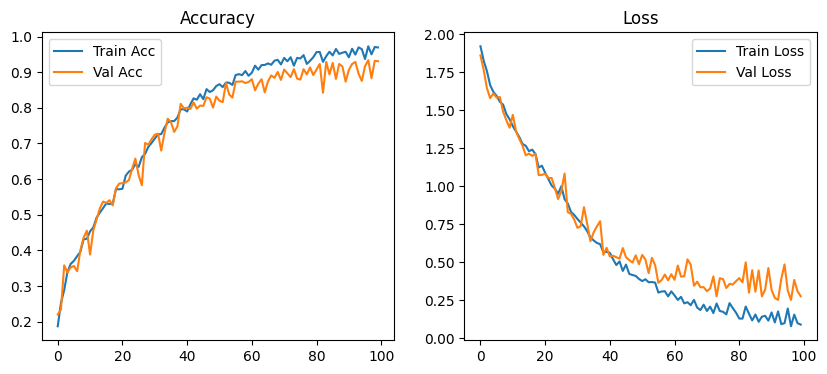

In [37]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [38]:
test_loss, test_accuracy = model_res.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f} %")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9445 - loss: 0.2309
Test Loss: 0.3096
Test Accuracy: 92.80 %


### Print classification report & Confusion matrix

In [39]:
from sklearn.metrics import accuracy_score, classification_report

# Get probabilities
y_pred_probs = model_res.predict(test_dataset)

# Convert to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Extract true labels from dataset
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

print(classification_report(y_true, y_pred_classes))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       160
           1       0.98      0.97      0.97       149
           2       0.97      0.95      0.96       120
           3       0.93      0.89      0.91       180
           4       0.83      0.97      0.90       108
           5       0.93      0.84      0.88       180
           6       0.91      0.97      0.94       131

    accuracy                           0.93      1028
   macro avg       0.93      0.93      0.93      1028
weighted avg       0.93      0.93      0.93      1028



In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

[[152   2   0   3   0   2   1]
 [  0 144   0   1   2   0   2]
 [  0   0 114   2   1   2   1]
 [  2   1   1 161   5   6   4]
 [  0   0   0   1 105   1   1]
 [  6   0   3   5  11 151   4]
 [  0   0   0   1   2   1 127]]


2025-10-17 10:25:33.391579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760696733.418225    8138 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760696733.426627    8138 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1760696738.003458    8138 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10881 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
2025-10-17 10:27:18.922 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_contain

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


### Use a pretrained ResNet50

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

pretrained_model = ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
pretrained_model.trainable = False

# Add an output Dense layers for calssification
model = models.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(7, activation="softmax")  # multi-class
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    X_final,y_final,
    validation_data=val_dataset,
    epochs=30
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - accuracy: 0.4167 - loss: 1.8256 - val_accuracy: 0.6829 - val_loss: 0.8572
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.6955 - loss: 0.8328 - val_accuracy: 0.8268 - val_loss: 0.5509
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.7879 - loss: 0.6094 - val_accuracy: 0.8755 - val_loss: 0.4042
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8320 - loss: 0.4539 - val_accuracy: 0.8969 - val_loss: 0.3439
Epoch 5/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8684 - loss: 0.3809 - val_accuracy: 0.9144 - val_loss: 0.3101
Epoch 6/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9006 - loss: 0.2911 - val_accuracy: 0.9183 - val_loss: 0.2683
Epoch 7/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9082 - loss: 0.2628 - val_accuracy: 0.9202 - val_loss: 0.2529
Epoch 8/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 5

In [27]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f} %")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9712 - loss: 0.0815
Test Loss: 0.1356
Test Accuracy: 95.53 %


# Use Streamlit for UI

In [28]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 84.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.8 MB/s eta 0:00:0000:01


In [29]:
model.save("mymodel.h5")

In [30]:
with open("app.py", "w") as f:
    f.write("""
import tensorflow as tf
import streamlit as st
from PIL import Image
import numpy as np

model_res = tf.keras.models.load_model("mymodel.h5")

classes = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

st.title("📷📝 Teeth Classification App")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_container_width=True)

    img = image.resize((224, 224))
    img = np.expand_dims(img, axis=0)

    if st.button("Classify"):
        status = st.empty()
        status.subheader("Image is being classified, please wait...")
        c = model_res.predict(img)
        y = np.argmax(c, axis=1)[0]
        status.subheader(f"Class is : {classes[y]}")
""")

In [31]:
from pyngrok import ngrok
import os

ngrok.kill()

NGROK_AUTH_TOKEN = "32O2LwP6mYTbP3rlUN9PTJ12OcJ_85Sfb9VrfwBvM1y3KNKDp"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)



# Kill anything already running on 8501
os.system("fuser -k 8501/tcp")

# Start Streamlit in background
get_ipython().system_raw("streamlit run app.py --server.headless true --server.port 8501 &")

# Connect with ngrok
public_url = ngrok.connect(8501)
print("🌍 Open this link:", public_url)


🌍 Open this link: NgrokTunnel: "https://6005ba29a58b.ngrok-free.app" -> "http://localhost:8501"    
